In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
import imutils
from skimage.filters import roberts, sobel, prewitt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


count the number of objects using libraries

In [3]:
def show(img, num, name, gray=True):
  plt.figure(figsize=(11,6))
  if gray:
    plt.subplot(num), plt.imshow(img[...,::-1], cmap='gray'),plt.title(name)
  else:
    plt.subplot(num), plt.imshow(img[...,::-1]),plt.title(name)
  plt.xticks([]), plt.yticks([])
def contours_with_library(img, show_all=False):
  clone = img.copy()
  show(img, 122,'original' )
  gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
  if show_all:
    show(gray, 122, 'gray')
  ret, gray_threshed = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
  bilateral_filtered_image = cv2.bilateralFilter(gray_threshed, 5, 175, 175)
  if show_all:
    show(bilateral_filtered_image, 121, 'bilateral_filtered_image')
  edge_detected_image = cv2.Canny(bilateral_filtered_image, 75, 200)
  if show_all:
    show(edge_detected_image, 122, 'edge_detected_image')
  contours, _ = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour_list = []
  for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        if ((len(approx) > 8) & (50000 > area > 10000)):
          contour_list.append(contour)
  cnts = cv2.findContours(edge_detected_image, cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  total = 0
  for c in cnts:
    if cv2.contourArea(c) < 25:
      continue
    cv2.drawContours(image, [c], -1, (204, 0, 255), 2)
    total += 1
  print("count of objects:", total)
  cv2.drawContours(img, contours, -1, (0, 0, 255), 3)
  show(img, 121, 'contours', False)
  plt.show()
def count_of_obj(im):
  cnts = imutils.grab_contours(cv2.findContours(im, cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE))
  total = 0
  for c in cnts:
    if cv2.contourArea(c) < 25:
      continue
    total += 1
  print("count of objects:", total)

count of objects: 16


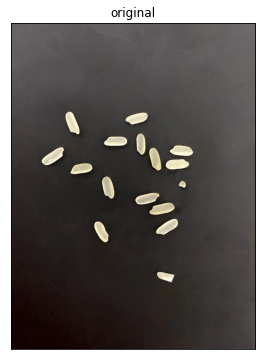

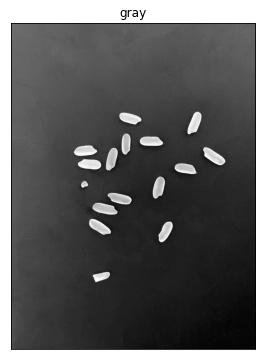

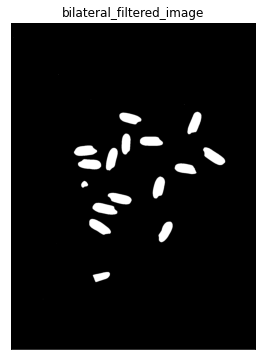

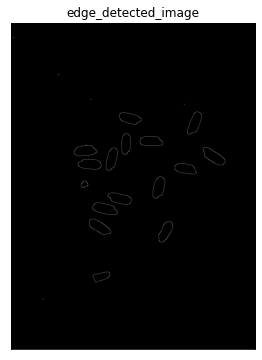

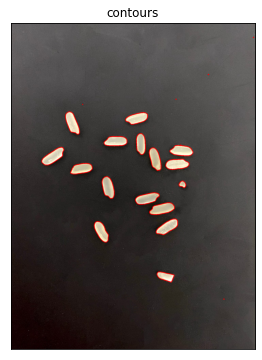

In [4]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris.png') 
contours_with_library(image, True)

count of objects: 15


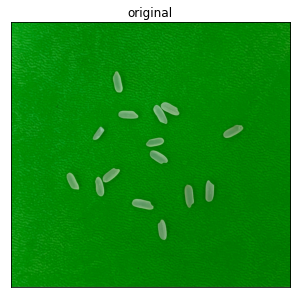

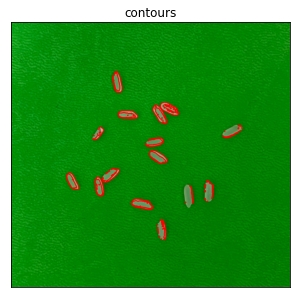

In [5]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris1.jpg') 
contours_with_library(image, False)

count of objects: 15


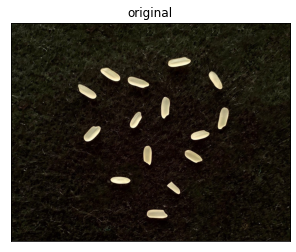

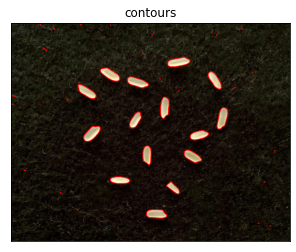

In [6]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/risinki1.jpg') 
contours_with_library(image)

count of objects: 20


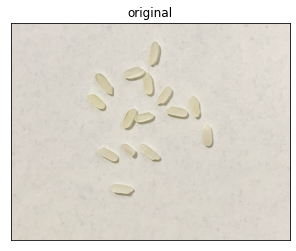

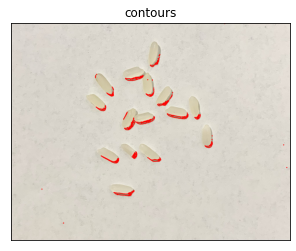

In [7]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris3.jpg') 
contours_with_library(image)

the function finds edges in a contrast image better

count the number of objects without using libraries. 
to find edges i need  to convert image to grayscale, to smooth image, use the edge detection filter,  find the edges

In [8]:
def to_gray(image): 
        height,width,  p = image.shape
        new_img = [] 
        to_gray_list=[0.2989, 0.5870, 0.1140] #rgb_weights 
        for x in range(height):
            n=[]
            for y in range(width):
                s=0
                for i in range(3):
                    s+=image[x][y][i]*to_gray_list[i]
                n.append(round(s))
            new_img.append(n)
        return np.asarray(new_img , dtype=np.float32)  
def median_filter(img, size=3):
  if (size%2==0):
    raise  Exception("Wrong size, enter an odd number")
  image = np.array(img, copy=True).astype(np.float32)
  processed = np.zeros_like(image)
  med = int(size/2)
  if len(img.shape) == 3: 
    r = np.zeros(size*size)
    g = np.zeros(size*size)
    b = np.zeros(size*size)
    for x in range(med, image.shape[0] - med):
        for y in range(med, image.shape[1] - med):
          cont = 0
          for i in range(x - med, x + med + 1):
                for j in range(y - med, y + med + 1):
                    r[cont] = image[i][j][0]
                    g[cont] = image[i][j][1]
                    b[cont] = image[i][j][2]
                    cont += 1
          r.sort()
          g.sort()
          b.sort()
          processed[x][y][0] = r[int(size*size/2)]
          processed[x][y][1] = g[int(size*size/2)]
          processed[x][y][2] = b[int(size*size/2)]
    processed = np.clip(processed,0,255).astype(np.uint8)
  else:
    l = np.zeros(size*size)
    for x in range(med, image.shape[0] - med):
        for y in range(med, image.shape[1] - med):
          cont = 0
          for i in range(x - med, x + med + 1):
                for j in range(y - med, y + med + 1):
                    l[cont] = image[i][j]
                    cont += 1
          l.sort()
          processed[x][y]= l[int(size*size/2)]
    processed = np.clip(processed,0,255).astype(np.uint8)
  return processed
def  binary(image,val):
    init   = np.where((image <= val), image, 255)
    final = np.where((init  >val), init , 0)
    return final 


def edge_filter(image, kernel):
  if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image_x, image_y = image.shape
  kernel_x, kernel_y = kernel.shape
  new_image_x= np.zeros(image.shape)
  new_height = int((kernel_x - 1) / 2)
  new_width = int((kernel_y - 1) / 2)
  new_image = np.zeros((image_x + (2 * new_height), image_y + (2 * new_width)))
  new_image[new_height:new_image.shape[0] - new_height, new_width:new_image.shape[1] - new_width] = image
  for x in range(image_x):
      for y in range(image_y):
          new_image_x[x, y] = np.sum(kernel * new_image[x:x + kernel_x, y:y + kernel_y])
          new_image_x[x, y] /= kernel.shape[0] * kernel.shape[1]
  kernel = np.flip(kernel.T, axis=0)
  kernel_x, kernel_y = kernel.shape
  new_image_y = np.zeros(image.shape)
  new_height = int((kernel_x - 1) / 2)
  new_width = int((kernel_y - 1) / 2)
  new_image = np.zeros((image_x + (2 * new_height), image_y + (2 * new_width)))
  new_image[new_height:new_image.shape[0] - new_height, new_width:new_image.shape[1] - new_width] = image
  for x in range(image_x):
      for y in range(image_y):
          new_image_y[x, y] = np.sum(kernel * new_image[x:x + kernel_x, y:y + kernel_y])
          new_image_y[x, y] /= kernel.shape[0] * kernel.shape[1]
          new_image_y[x, y] = round(new_image_y[x, y])#####################################

  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  gradient_magnitude *= 255.0 / gradient_magnitude.max()
  return gradient_magnitude 

def prewitt_filter(image):
  kernel = np.array([[-1, 0, 1], 
                     [-1, 0, 1],
                     [-1, 0, 1]])
  return edge_filter(image, kernel)      

In [11]:
# image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris.png') 
# gray_img=to_gray(image)
# plt.figure(figsize=(11,6))
# plt.subplot(121), plt.imshow(gray_img, cmap='gray'),plt.title('gray')
# plt.xticks([]), plt.yticks([])
# plt.show()


In [ ]:
# blurred_img=median_filter(gray_img) 
# plt.figure(figsize=(11,6))
# plt.subplot(121), plt.imshow(blurred_img, cmap='gray'),plt.title('blurred')
# plt.xticks([]), plt.yticks([])
# plt.show()

In [ ]:
# binar_img=binary(blurred_img,128)
# plt.figure(figsize=(11,6))
# plt.subplot(121), plt.imshow(binar_img, cmap='gray'),plt.title('binar')
# plt.xticks([]), plt.yticks([])
# plt.show()

In [ ]:
# edges_img= prewitt_filter(blurred_img) 
# plt.figure(figsize=(11,6))
# plt.subplot(121), plt.imshow(edges_img, cmap='gray'),plt.title('edges')
# plt.xticks([]), plt.yticks([])
# plt.show()


In [12]:
def edges(image, show_all=True):
  show(image, 121, 'original', False)
  gray_img=to_gray(image)
  if show_all:
    show(gray_img, 122, 'gray')
  blurred_img=median_filter(gray_img, 9)
  if show_all:
    show(blurred_img, 121, 'blurred') 
  binar_img=binary(blurred_img,128)
  if show_all:
    show(binar_img, 122, 'binar') 
  edges_img= prewitt_filter(binar_img)
  if show_all:
    show(edges_img, 121, 'edges') 
  plt.figure(figsize=(11,6))
  contours = plt.contour(binary(edges_img,128), colors='red')
  plt.imshow(image)
  plt.xticks([]), plt.yticks([])
  plt.show() 
  return binar_img


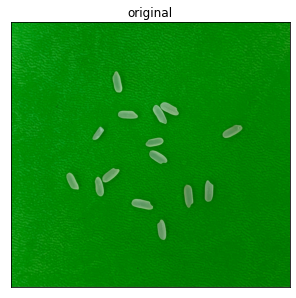

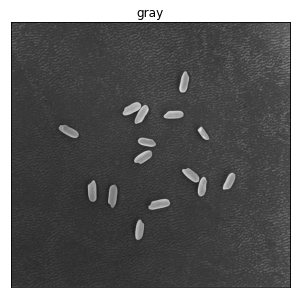

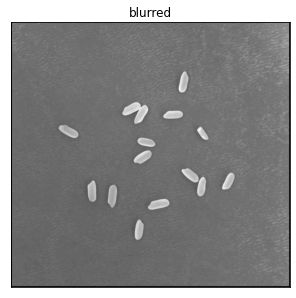

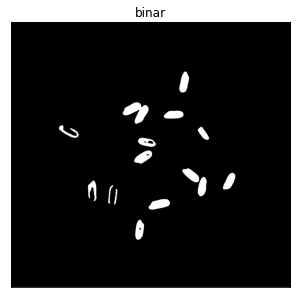

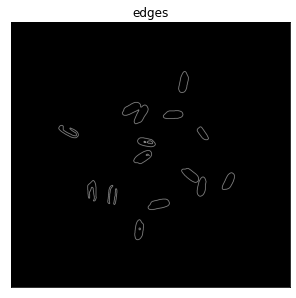

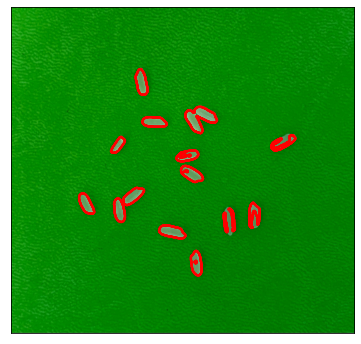

In [13]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris1.jpg') 
im=edges(image)

In [14]:
count_of_obj(im)

count of objects: 15


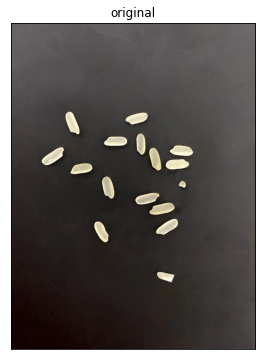

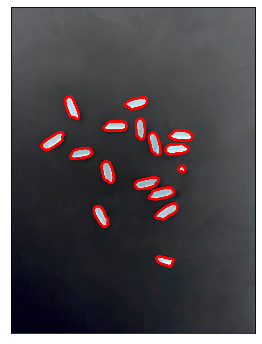

count of objects: 16


In [15]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/ris.png') 
im = edges(image, False)
count_of_obj(im)